# Séance 4 - Bonus : Réseau récurrent avec Embedding

Dans cette séance nous avons entraîné un modèle à copier le style de poésie de Beaudelaire, spécifiquement l'oeuvre *Les fleurs du mal*. On souhaite voir ici comment utiliser la couche [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) et ce que l'on peut faire avec.

Commençons par importer les données.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow import keras

start = False
book = open("Beaudelaire.txt", 'r', encoding='utf8')
lines = book.readlines()
verses = []

for line in lines:
    line = line.strip().lower()
    if ("AU LECTEUR".lower() in line and start == False):
        start = True
    if ("End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower() in line):
        break
    if (start == False or len(line) == 0):
        continue
    verses.append(line)

book.close()
text = " ".join(verses)
characters = sorted(set([character for character in text]))
n_characters = len(characters)

Dans le TP principal nous avons one-hot encodé le texte. La couche [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) prend en entrée une séquence d'entier. Ainsi, nous devons changer la manière de construire $X$ et $y$.

**Consigne** : En s'inspirant du travail précédent, construire la matrice d'informations $X$ et le vecteur réponse $y$. Puis on scindera le dataset en un dataset d'entraînement et de validation.

In [2]:
sequence_length = 32
stride = 1
sequences = []
y_character = []
for index in range(0, len(text) - sequence_length, stride):
    sequences.append(text[index:(index + sequence_length)])
    y_character.append(text[index + sequence_length])

character_to_index = dict((character, index) for index, character in enumerate(characters))
index_to_character = dict((index, character) for index, character in enumerate(characters))

X = np.zeros((len(sequences), sequence_length), dtype=int)
y = np.zeros((len(sequences),), dtype=int)

for row, sequence in enumerate(sequences):
    for position, character in enumerate(sequence):
        X[row][position] = character_to_index[character]
    y[row] = character_to_index[y_character[row]]

train_size = 0.8
train_index = int(round(len(sequences) * train_size))
X_train = X[:train_index, :]
y_train = y[:train_index]

X_test = X[train_index:, :]
y_test = y[train_index:]

La couche [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) a comme paramètre :
* *input_dim* : la taille du vocabulaire que l'on considère, ici *n_characters*
* *output_dim* : la dimension de l'embedding, autrement dit chaque caractère sera représenté comme un vecteur de *output_dim* dimension

On souhaite mesurer l'impact du paramètre *output_dim*. 

**Consigne** : Définir une fonction `get_model` qui prend en paramètre:
* *dimension* : un entier qui correspond à la dimension de sortie de l'embedding
* *vocabulary_size* : la taille du vocabulaire

La fonction renvoie un réseau de neurones récurrents avec une couche d'embedding paramétré en accord avec les paramètres de la fonction. On essayera de faire un modèle de taille raisonnable.


In [3]:
def get_model(dimension, vocabulary_size):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(sequence_length,)),
        keras.layers.Embedding(input_dim=vocabulary_size, output_dim=dimension),
        keras.layers.SimpleRNN(64, return_sequences=True, activation="relu", kernel_initializer="he_normal", unroll=True),
        keras.layers.LayerNormalization(),
        keras.layers.SimpleRNN(64, return_sequences=False, activation="relu", kernel_initializer="he_normal", unroll=True),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dense(units=n_characters, activation='softmax')
    ])
    
    return model

**Consigne** : Écrire une boucle d'entraînement qui va stocker dans une liste le maximum atteint lors de l'entraînement jusqu'à 10 époques. Chaque élément de la liste correspondra à un dictionnaire avec pour clé:
* *dimension*: la dimension de l'embedding
* *val_loss*: la valeur de loss minimale atteinte sur le dataset de validation au cours de l'entraînement

In [25]:
batch_size = 128
n_epochs = 10               
learning_rate = 1e-3
weight_decay = 1e-4

comparison_number = 3
dimensions = [2 ** index for index in range(1, 7)]
results = []

for dimension in dimensions:
    print(f"Dimension = {dimension}...\t", end=" ")

    for _ in range(comparison_number):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        callbacks = [early_stopping]
        model = get_model(dimension=dimension, vocabulary_size=n_characters)
        model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=["accuracy"])
        history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=callbacks, verbose=0)
        min_loss = min(pd.DataFrame(history.history)["val_loss"])
        result = {"dimension": dimension, "val_loss": min_loss}
        results.append(result)
        print(round(min_loss, 4), end="\t")
    
    print()

Dimension = 2...	 1.848	1.8673	1.89	
Dimension = 4...	 1.8047	1.7807	1.8134	
Dimension = 8...	 1.7612	1.7637	1.767	
Dimension = 16...	 1.7587	1.7677	1.7653	
Dimension = 32...	 1.7466	1.7538	1.7559	
Dimension = 64...	 1.7524	1.7517	1.7397	


**Consigne** : Modifier la structure de results pour correspondre à une liste de tuple où on a la moyenne et l'écart-type pour chaque entraînement pour une dimension précise.

In [ ]:
results = [np.array([result["val_loss"] for result in results if result["dimension"] == dimension])for dimension in dimensions]
results = [(vector.mean(), vector.std()) for vector in results]

**Consigne** : Visualiser puis commenter les résultats.

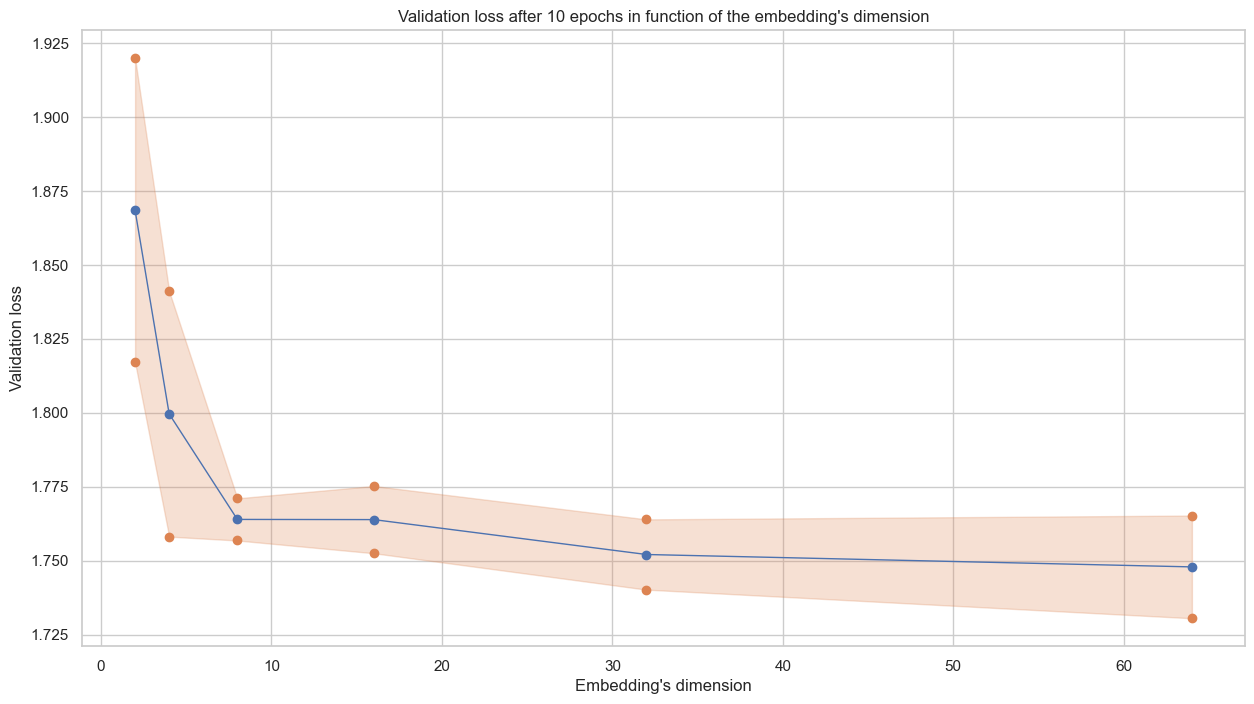

In [28]:
means = np.array([stats[0] for stats in results])
std = np.array([stats[1] for stats in results])
alpha = 3


plt.figure(figsize=(15, 8))
plt.fill_between(dimensions, means - alpha * std, means + alpha * std, color=sns.color_palette()[1], alpha=0.25)
plt.plot(dimensions, means + alpha * std, 'o', color=sns.color_palette()[1])
plt.plot(dimensions, means - alpha * std, 'o', color=sns.color_palette()[1])
plt.plot(dimensions, means, 'o-', color=sns.color_palette()[0], lw=1)

plt.xlabel("Embedding's dimension")
plt.ylabel("Validation loss")
plt.title("Validation loss after 10 epochs in function of the embedding's dimension")
plt.show()

Une dimension d'embedding trop petite conduit à une fonction de perte sur le dataset de validation grande. L'optimal en terme de performance par rapport au nombre de paramètre du modèle semble être 32. Rappelons que la dimension du vocabulaire initiale est faible (54). 
On obtient par ailleurs des résultats tout à fait satisfaisant avec un embedding de dimension 8, surtout que l'on a un apprentissage stable.